Hanel et al., iScience 2025

### Fig. 3: PCA based on 24 features 
- G1/S genes; receptors; HVGs; random 

In [2]:
library(tidyverse)
library(data.table)
library(matrixStats)
library(ggplot2)
library(anndata)
library(edgeR)
library(scales)
library(RColorBrewer)

#to be able to adjust figs
fig <- function(width, heigth){
options(repr.plot.width = width, repr.plot.height = heigth) }

set.seed(333) 
Sys.time()


[1] "2025-04-26 14:15:02 EEST"

In [3]:
ad <- read_h5ad ("/research/work/andreha/privat/Andrea/2025_Sylvain/data/pdata_HCAmt_MAD5_Level1.h5ad")

ad$obs$cell_type =  as.factor(ad$obs$`Level 1`)

Level 1 object: MAD5 outlier filtered and MT filtered, but not 68-types filtered


In [4]:
ad

AnnData object with n_obs × n_vars = 204 × 20898
    obs: 'donor_id', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [5]:
geneinfo = (ad$var)

In [6]:
#----------
MIN_CELLS = 10
MIN_READS =50000 #50.000 as in EdgeR notebook

keep.samples <-  ad$obs$psbulk_n_cells >= MIN_CELLS
table(keep.samples)

ad_filtr <- subset(ad, ad$obs$psbulk_n_cells >= MIN_CELLS)
keep.samples <-  ad_filtr$obs$psbulk_counts >= MIN_READS
table(keep.samples)

ad_filtr <- subset(ad_filtr, ad_filtr$obs$psbulk_counts >= MIN_READS)
ad_filtr

keep.samples
FALSE  TRUE 
    7   197 

keep.samples
TRUE 
 197 

View of AnnData object with n_obs × n_vars = 197 × 20898
    obs: 'donor_id', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [7]:
cell_type_counts <- ad_filtr$obs %>%
  group_by(cell_type) %>%
  summarise(donor_count = n_distinct(donor_id))

low_donor_cell_types <- cell_type_counts %>%
  filter(donor_count < 5) %>%
  pull(cell_type)

ad_filtr <- subset(ad_filtr, !ad_filtr$obs$cell_type %in% low_donor_cell_types)

In [8]:
ad_filtr

View of AnnData object with n_obs × n_vars = 197 × 20898
    obs: 'donor_id', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [9]:
low_donor_cell_types

factor()
25 Levels: ASDC B cell Ba/Ma/Eo CD4 T-cell CLP GMP HSC MDP MEP MKP ... pre-DC

In [10]:
cell_type_counts <- ad_filtr$obs %>%
  group_by(cell_type) %>%
  summarise(n_donors = n_distinct(donor_id)) %>%
  arrange(desc(n_donors)) 

cell_type_counts

cell_type,n_donors
<fct>,<int>
ASDC,8
B cell,8
CD4 T-cell,8
CLP,8
GMP,8
HSC,8
MDP,8
MEP,8
MKP,8


In [11]:
ad_filtr <- subset(ad_filtr, 
                   !ad_filtr$obs$cell_type %in% "Ba/Ma/Eo")

In [12]:
levels(ad_filtr$obs$cell_type)  
ad_filtr$obs$cell_type <- factor(ad_filtr$obs$cell_type) 
nlevels(ad_filtr$obs$cell_type) 

[1] "ASDC"                 "B cell"               "CD4 T-cell"          
 [4] "CLP"                  "GMP"                  "HSC"                 
 [7] "MDP"                  "MEP"                  "MKP"                 
[10] "MPP"                  "Monocyte"             "MultiLin"            
[13] "Myeloid intermediate" "Plasma Cell"          "T/NK"                
[16] "Transitional-B"       "cDC"                  "early-Erythroid"     
[19] "early-Mono"           "early-Neu"            "late-Erythroid"      
[22] "pDC"                  "pre-B"                "pre-DC"

[1] 24

In [13]:
ad_filtr

AnnData object with n_obs × n_vars = 192 × 20898
    obs: 'donor_id', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [14]:
#write_h5ad(ad_filtr, "./data/Level1_pbulk_192samples.h5ad")

In [15]:
colorcode <- c( 
  "HSC"   = "#ffb6ca",   
  "MPP" = "#ff7ca6",   
  "MultiLin" = "#CCC5ED",  
  "MEP" = "#ffa799",
  "early-Erythroid" = "#fe625b",
  "late-Erythroid" = "#ac131f",
  "MKP" = "#C4A09A",  
  "CLP" = "#a7dde7",  
  "Transitional-B" = "#3bafc7",   
  "pre-B" = "#276C9B",   
  "B cell" = "#173B69",  
  "Plasma Cell" = "#0C2048",    
  "CD4 T-cell" = "#6C2E44",  
  "T/NK" = "#522E48",  
   "GMP" = "#D2BFAF",  
  "early-Neu"    = "#d4cfc9",  
  "Myeloid intermediate" = "#F5DBBF",  
  "early-Mono" = "#E0B89F",  
  "Monocyte" = "#983306",  
  "MDP"     = "#f3b9ad",
  "pre-DC"  = "#d78e83",
  "cDC"    = "#97504d",
  "ASDC" = "#C46A71",  
  "pDC" = "#BC4F57"  
)
labelorder = names (colorcode)

In [16]:
levels(ad$obs$cell_type)

[1] "ASDC"                 "B cell"               "Ba/Ma/Eo"            
 [4] "CD4 T-cell"           "CLP"                  "GMP"                 
 [7] "HSC"                  "MDP"                  "MEP"                 
[10] "MKP"                  "MPP"                  "Mac"                 
[13] "Monocyte"             "MultiLin"             "Myeloid intermediate"
[16] "Plasma Cell"          "T/NK"                 "Transitional-B"      
[19] "cDC"                  "early-Erythroid"      "early-Mono"          
[22] "early-Neu"            "late-Erythroid"       "pDC"                 
[25] "pre-B"                "pre-DC"

In [17]:
sampleinfo = ad$obs
sampleinfo$cell_type <- factor(sampleinfo$cell_type, levels = labelorder)
#df <- sampleinfo[order(sampleinfo$cell_type), ]

In [18]:
x = t(ad_filtr$X)
head(x)

sampleinfo = ad_filtr$obs %>%
#select (., -c("sample")) %>%
rownames_to_column ("sample")

sampleinfo$cell_type <- droplevels(sampleinfo$cell_type)
#head(sampleinfo)

,BM1_ASDC,BM2_ASDC,BM3_ASDC,BM4_ASDC,BM5_ASDC,BM6_ASDC,BM7_ASDC,BM8_ASDC,BM1_B cell,BM2_B cell,⋯,BM7_pre-B,BM8_pre-B,BM1_pre-DC,BM2_pre-DC,BM3_pre-DC,BM4_pre-DC,BM5_pre-DC,BM6_pre-DC,BM7_pre-DC,BM8_pre-DC
A1BG,6,9,16,14,12,8,16,22,73,130,⋯,114,37,33,8,30,71,31,48,24,57
A1BG-AS1,0,0,0,2,0,0,0,0,2,19,⋯,1,0,6,3,2,12,1,3,2,1
A1CF,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,1,0,0,0,0,⋯,0,0,1,1,1,1,1,0,1,0
A2M-AS1,1,0,1,0,0,0,1,0,0,8,⋯,5,0,0,0,0,1,3,4,3,1
A2ML1,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [19]:
table(colnames(x)==sampleinfo$sample)

y <- DGEList (counts =x, 
              group = sampleinfo$cell_type, 
              genes = rownames (x))

keep <- filterByExpr(y)
table(keep)



TRUE 
 192 

keep
FALSE  TRUE 
 9638 11260 

In [20]:
y <- calcNormFactors(y, method = "TMM") #default in TMM
head(y$samples)

min (y$samples$norm.factors)
max (y$samples$norm.factors)

#cpm <- cpm(y, normalized.lib.sizes=TRUE)
logcpm <- cpm(y, log=TRUE,normalized.lib.sizes=TRUE)
#head (logcpm)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
BM1_ASDC,ASDC,128299,1.465480
BM2_ASDC,ASDC,94350,1.419754
BM3_ASDC,ASDC,254625,1.162618
BM4_ASDC,ASDC,165164,1.402990
BM5_ASDC,ASDC,365020,1.025510
BM6_ASDC,ASDC,143945,1.425810


[1] 0.3149338

[1] 1.775997

## PCA

In [21]:
G1Sgenes = c("CCND1","CCND2","CCND3","CCNE1","CCNE2", #cyclins
           "RB1","RBL1","RBL2", #RB related proteins
           "CDK2","CDK4","CDK6",
           "E2F1","E2F2","E2F3",
            "CDC25A","CDKN1A","CDKN1B","CDKN1C","CDKN2A","CDKN2B","CDKN2C","CDKN2D","CDKN3", "MYC")

logcpm_CC = logcpm[G1Sgenes,]
logcpm_CC_t = t(logcpm_CC)

pca <- prcomp((logcpm_CC_t), scale. = TRUE)

In [22]:
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

# Extract variance explained by PC1 and PC2
variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)

In [23]:
colorcode <- c(
  "HSC"   = "#fbd1dc",  
  "MPP"   = "#ff9bb9",  
  "MultiLin" = "#CCC5ED",   
  "MEP" = "#ffa799",
  "early-Erythroid" = "#eb323d",
  "late-Erythroid" = "#780b17",
  "MKP" = "#C4A09A",   
  "CLP" = "#a7dde7",   
  "Transitional-B" = "#3bafc7",   
  "pre-B" = "#276C9B",   
  "B cell" = "#173B69",  
  "Plasma Cell" = "#0C2048",  
  "CD4 T-cell" = "#6C2E44",  
  "T/NK" = "#522E48",  
  "GMP" = "#D2BFAF",  
  "early-Neu"    = "#d4cfc9",  
  "Myeloid intermediate" = "#FBE4CA",  
  "early-Mono" = "#E0B89F",    
  "Monocyte" = "#983306",  
  "MDP"     = "#f3b9ad",
  "pre-DC"  = "#d78e83",
  "cDC"      = "#b26358",
  "ASDC" = "#C46A71",  
  "pDC" = "#BC4F57"  
)
labelorder = names (colorcode)

In [38]:
sampleinfo$cell_type <- factor(sampleinfo$cell_type, levels = labelorder)
colorcode <- colorcode[labelorder]

plotmypca <- function(data, variance_pc1, variance_pc2, colorcode, sampleinfo) {
  ggplot(data, 
         aes(x = pca.x...1., 
             y = pca.x...2.,
             fill = sampleinfo$cell_type)) +  
    geom_point(shape = 21, size = 4, color = "darkgrey", stroke = 0.25) +  # circle with grey border
    xlab(paste0("PC1 (", variance_pc1, "%)")) +
    ylab(paste0("PC2 (", variance_pc2, "%)")) +
    scale_fill_manual(values = colorcode) +
    theme_classic(base_size = 20, base_family = "sans") +
    theme(
      aspect.ratio = 1, 
      axis.text = element_text(size = 16), 
      axis.title = element_text(size = 20), 
      axis.title.x = element_text(vjust = -1),
      plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
      legend.title = element_text(color = "black", size = 18, face = "bold"), 
      legend.text = element_text(color = "black", size = 18),
      axis.line.x = element_line(size = 1),
      axis.line.y = element_line(size = 1)
    ) +
    labs(fill = "Cell type") +
    guides(
      fill = guide_legend(
        title = "Cell type",
        override.aes = list(shape = 22, size = 5, stroke = 0)  # squares in legend
      )
    )
}


### without circle

In [36]:
sampleinfo$cell_type <- factor(sampleinfo$cell_type, levels = labelorder)
colorcode <- colorcode[labelorder]

plotmypca <- function(data, variance_pc1, variance_pc2, colorcode, sampleinfo) {
  data$cell_type <- sampleinfo$cell_type  # cell_type into data
  
  ggplot(data, 
         aes(x = pca.x...1., 
             y = pca.x...2.,
             color = cell_type)) + 
    geom_point(shape = 16, size = 4) + 
    xlab(paste0("PC1 (", variance_pc1, "%)")) +
    ylab(paste0("PC2 (", variance_pc2, "%)")) +
    scale_color_manual(values = colorcode) +  
    theme_classic(base_size = 20, base_family = "sans") +
    theme(
      aspect.ratio = 1, 
      axis.text = element_text(size = 16), 
      axis.title = element_text(size = 20), 
      axis.title.x = element_text(vjust = -1),
      plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
      legend.title = element_text(color = "black", size = 18, face = "bold"), 
      legend.text = element_text(color = "black", size = 18),
      axis.line.x = element_line(size = 1),
      axis.line.y = element_line(size = 1)
    ) +
    labs(color = "Cell type") +  
    guides(
      color = guide_legend(
        title = "Cell type",
        override.aes = list(shape = 16, size = 5) 
      )
    )
}


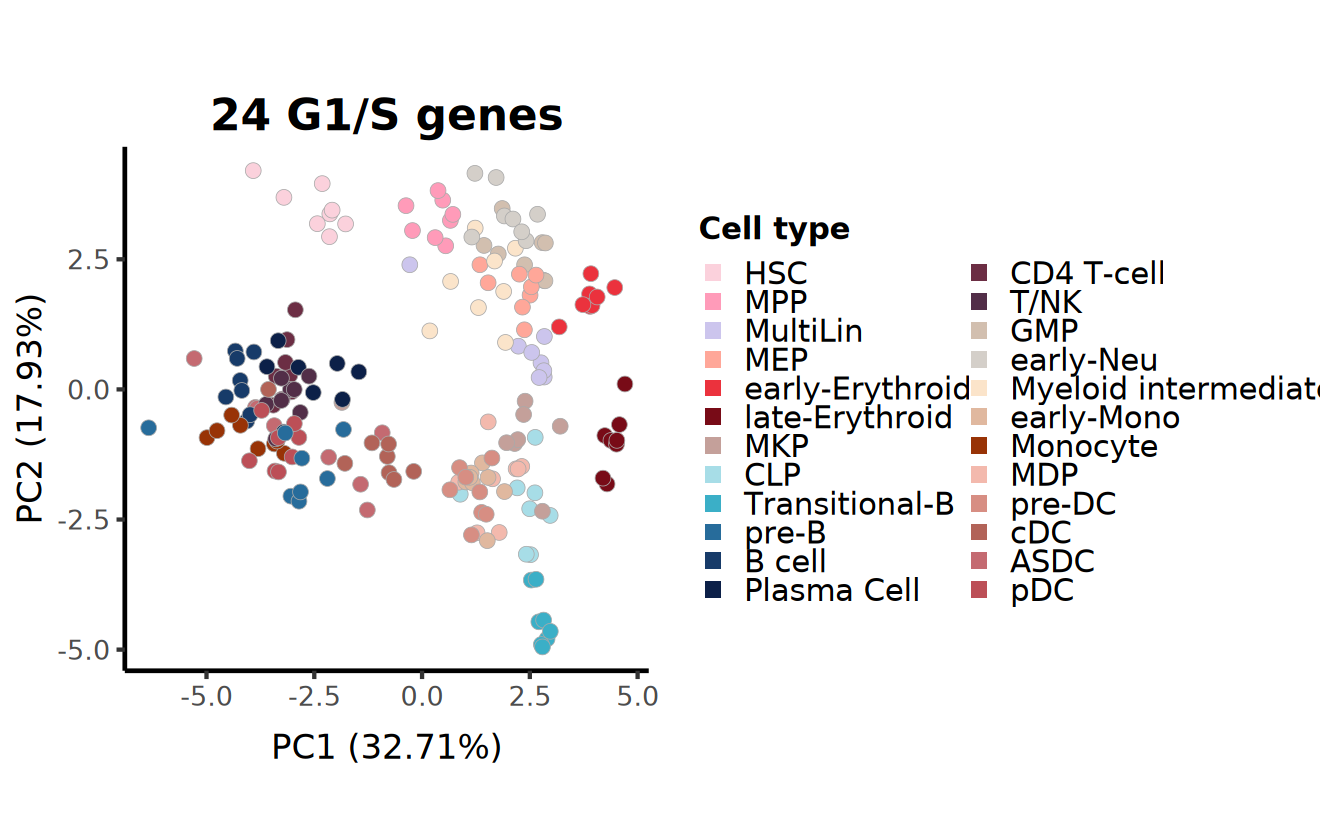

In [39]:
#--------
pca <- prcomp((logcpm_CC_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)



fig (11,7)
pca_plot1 <- plotmypca(pca_df, variance_pc1, variance_pc2, colorcode, sampleinfo) +
  ggtitle("24 G1/S genes")

pca_plot1
# Save the plot
#ggsave("pca_24_G1S_genes.pdf", plot = pca_plot, width = 11, height = 7, units = "in", dpi = 300)


In [209]:
#ggsave("./data/pca_withlegend.pdf", 
#       plot = pca_plot1, width = 11, height = 7, units = "in", dpi = 300)
#

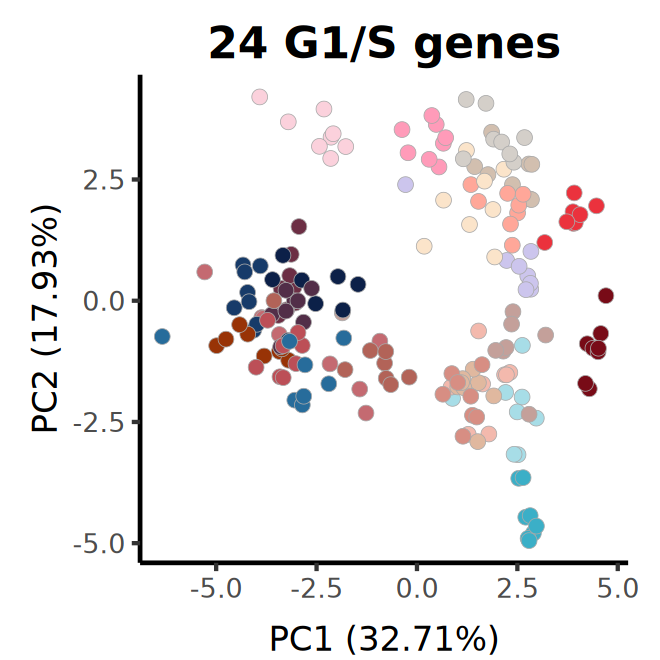

In [210]:
fig (5.5,5.5)

pca_plot1 = pca_plot1+theme(legend.position = "none")
pca_plot1
#ggsave("./data/pca_plot1.pdf", plot = pca_plot1, width = 5.5, height = 5.5)#, units = "in", dpi = 300)

In [211]:
pca_CC24 = pca_df %>%
rename (., "x" = "pca.x...1.", 
        "y" = "pca.x...2."
       )%>%
rownames_to_column ("sample")
head(pca_CC24)

,sample,x,y
,<chr>,<dbl>,<dbl>
1,BM1_ASDC,-2.166090,-1.3023192
2,BM2_ASDC,-5.285326,0.5934052
3,BM3_ASDC,-1.425685,-1.8221419
4,BM4_ASDC,-3.427387,-0.6959131
5,BM5_ASDC,-1.269101,-2.3166223
6,BM6_ASDC,-3.865045,-0.3463169


In [212]:
write.csv(pca_CC24, "./data/pca_CC24.csv", row.names = FALSE)

## 24 HVG

In [174]:
m = as.matrix(logcpm)

#https://support.bioconductor.org/p/9148563/

o <- order(rowVars(m), decreasing = TRUE)
cpm_ordered <- m[o,]

vargenes = rownames(cpm_ordered[1:24,])

cpm_ordered = cpm_ordered[vargenes,]
cpm_ordered_t = t(cpm_ordered)

pca <- prcomp((cpm_ordered_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

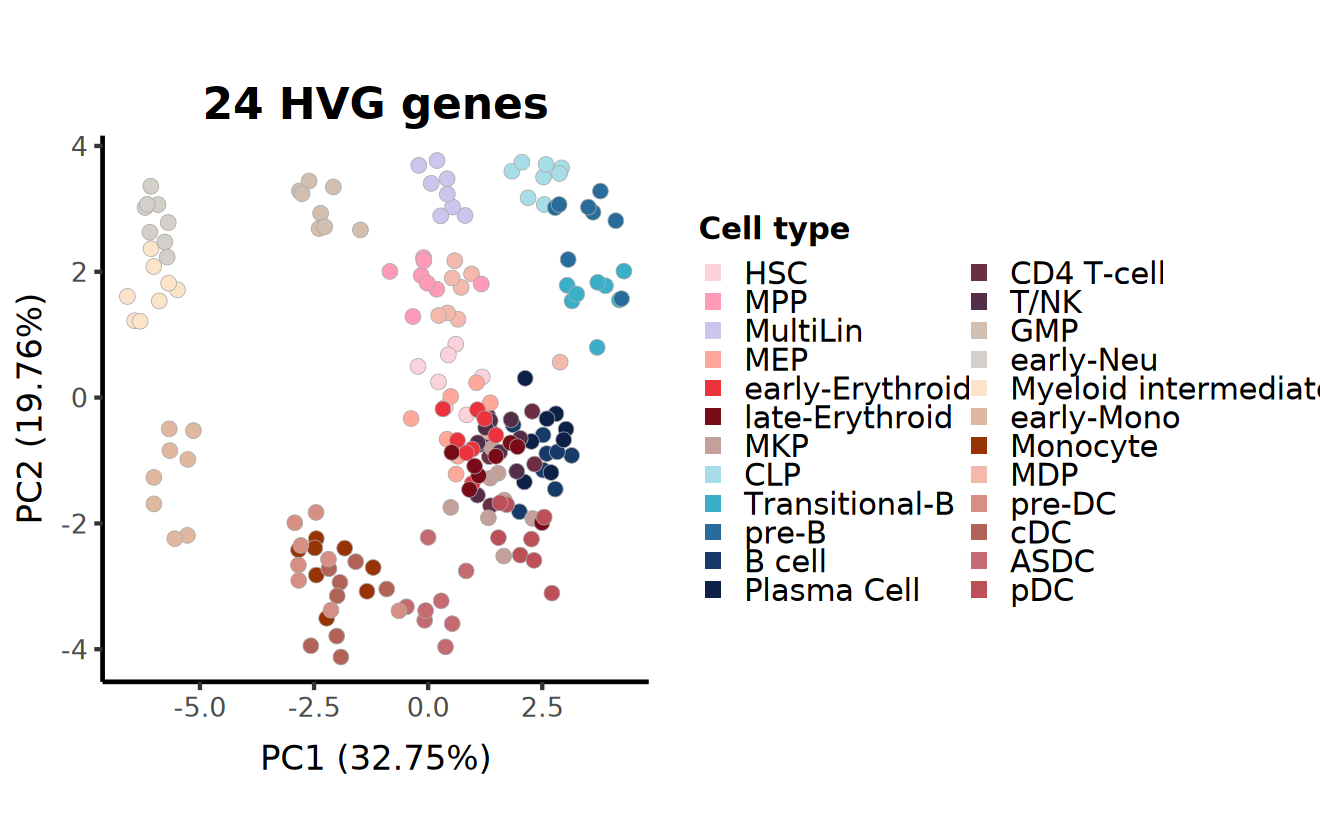

In [175]:
variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)


fig (11,7)
pca_plot2 <- plotmypca(pca_df, variance_pc1, variance_pc2, colorcode, sampleinfo) +
  ggtitle("24 HVG genes")

pca_plot2
#ggsave("pca_24_G1S_genes.pdf", plot = pca_plot, width = 11, height = 7, units = "in", dpi = 300)

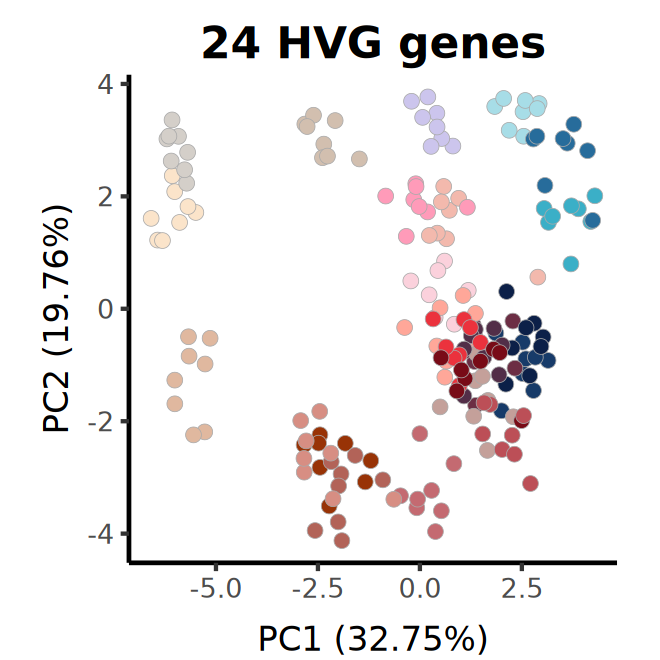

In [176]:
fig (5.5,5.5)

pca_plot2 = pca_plot2+theme(legend.position = "none")
pca_plot2

ggsave("./data/pca_plot2.pdf", plot = pca_plot2, width = 5.5, height = 5.5)#, units = "in", dpi = 300)

In [177]:
pca_hvg24 = pca_df %>%
rename (., "x" = "pca.x...1.", 
        "y" = "pca.x...2."
       )%>%
rownames_to_column ("sample")
head(pca_hvg24)

,sample,x,y
,<chr>,<dbl>,<dbl>
1,BM1_ASDC,0.8330919158,-2.754932
2,BM2_ASDC,0.5263647871,-3.593792
3,BM3_ASDC,-0.0762007939,-3.540178
4,BM4_ASDC,-0.0558678716,-3.385817
5,BM5_ASDC,-0.0007050353,-2.221834
6,BM6_ASDC,0.2865403161,-3.231227


In [178]:
write.csv(pca_hvg24, "./data/pca_hvg24.csv", row.names = FALSE)


## Random 24

In [179]:
set.seed(42)

logcpm2 = data.frame(logcpm) %>%
rownames_to_column ("gene")

logcpm3 <- data.table(logcpm2)
randomgenes = (logcpm3[sample(.N, 24)])$gene
#randomgenes

logcpm_random = logcpm[randomgenes,]
logcpm_random_t = t(logcpm_random)

pca <- prcomp((logcpm_random_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])
#head(logcpm_random_t)

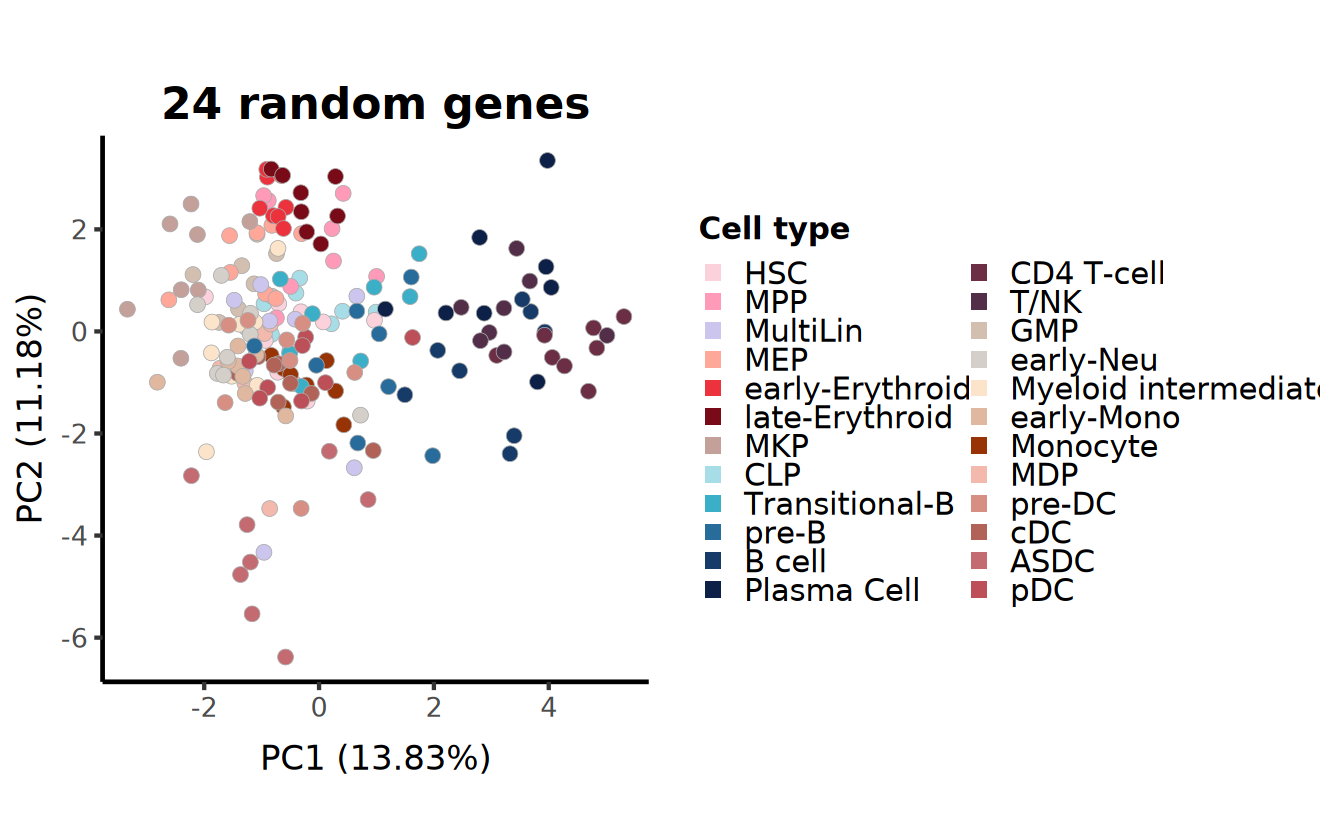

In [180]:
variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)

fig (11,7)
pca_plot3 <- plotmypca(pca_df, variance_pc1, variance_pc2, colorcode, sampleinfo) +
  ggtitle("24 random genes")

pca_plot3
#ggsave("pca_24_G1S_genes.pdf", plot = pca_plot, width = 11, height = 7, units = "in", dpi = 300)

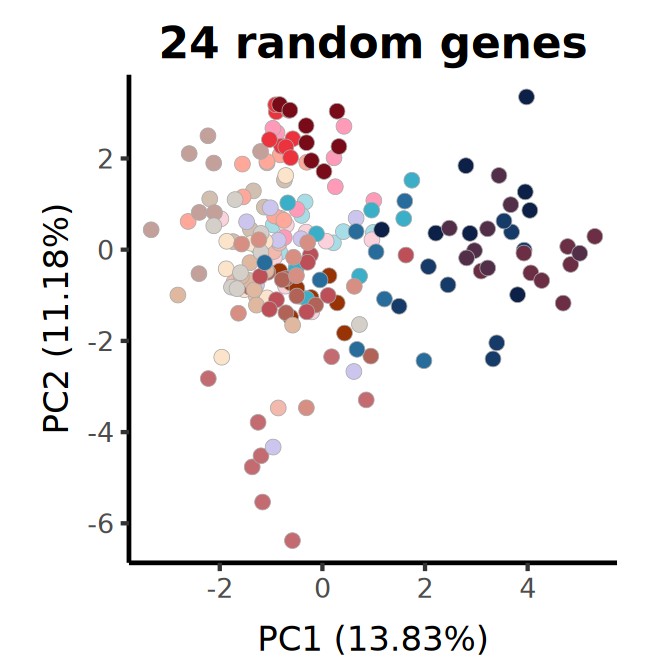

In [181]:
fig (5.5,5.5)

pca_plot3 = pca_plot3+theme(legend.position = "none")
pca_plot3

ggsave("./data/pca_plot3.pdf", plot = pca_plot3, width = 5.5, height = 5.5)#, units = "in", dpi = 300)

In [182]:
pca_random24 = pca_df %>%
rename (., "x" = "pca.x...1.", 
        "y" = "pca.x...2."
       )%>%
rownames_to_column ("sample")
head(pca_random24)

,sample,x,y
,<chr>,<dbl>,<dbl>
1,BM1_ASDC,-0.5836722,-6.379669
2,BM2_ASDC,-2.2233472,-2.826207
3,BM3_ASDC,-1.3680967,-4.763889
4,BM4_ASDC,0.1787343,-2.347719
5,BM5_ASDC,-1.1964804,-4.519464
6,BM6_ASDC,-1.1659961,-5.533613


In [184]:
write.csv(pca_random24, "./data/pca_random24.csv", 
          row.names = FALSE)


In [59]:
receptor_genes = c(
  "KIT", "CASR", "TNFRSF1A", "TNFRSF1B", "CSF3R", "CSF2RA", "CSF2RB", "IL6R",
  "CXCR4", "CXCR1", "CXCR2", "TGFBR1", "TGFBR2", "FGFR1", "IL1R1", "TNFRSF13B",
  "MPL", "LEPR", "CD44", "TFRC", "CD27", "CCR2", "FOLR2", "NGFR"
)


In [186]:
length(receptor_genes)

[1] 24

In [187]:
missing_genes <- receptor_genes[!receptor_genes %in% rownames(logcpm)]
missing_genes

character(0)

In [188]:
head(geneinfo, n=2)

,gene_ids,gene_count,ensembl_gene_id,entrezgene_id,external_gene_name,hgnc_symbol,description,chromosome_name,start_position,end_position,gene_biotype,strand,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,ENSG00000121410,17555,ENSG00000121410,1,A1BG,A1BG,alpha-1-B glycoprotein,19,58345178,58353492,protein coding,-1,FALSE,17546,0.21496521,0.19471544,82.75679,21874,9.993100
A1BG-AS1,ENSG00000268895,1163,ENSG00000268895,503538,A1BG-AS1,A1BG-AS1,A1BG antisense RNA 1,19,58347718,58355455,lncRNA,1,FALSE,1163,0.01168481,0.01161707,98.85707,1189,7.081708


In [189]:
str(geneinfo$hgnc_symbol)
head(geneinfo$hgnc_symbol)

 chr [1:20898] "A1BG" "A1BG-AS1" "A1CF" "A2M" "A2M-AS1" "A2ML1" "A2ML1-AS1" ...


[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1"  "A2ML1"

In [190]:
table(receptor_genes %in% rownames(geneinfo))


TRUE 
  24 

In [191]:
geneinfo$hgnc_symbol <- as.character(geneinfo$hgnc_symbol)
receptor_genes <- as.character(receptor_genes)

geneinfo_subset <- subset(geneinfo, hgnc_symbol %in% receptor_genes)

In [192]:
#write.table (geneinfo_subset, "./data/receptor_genes.csv", sep = ",")

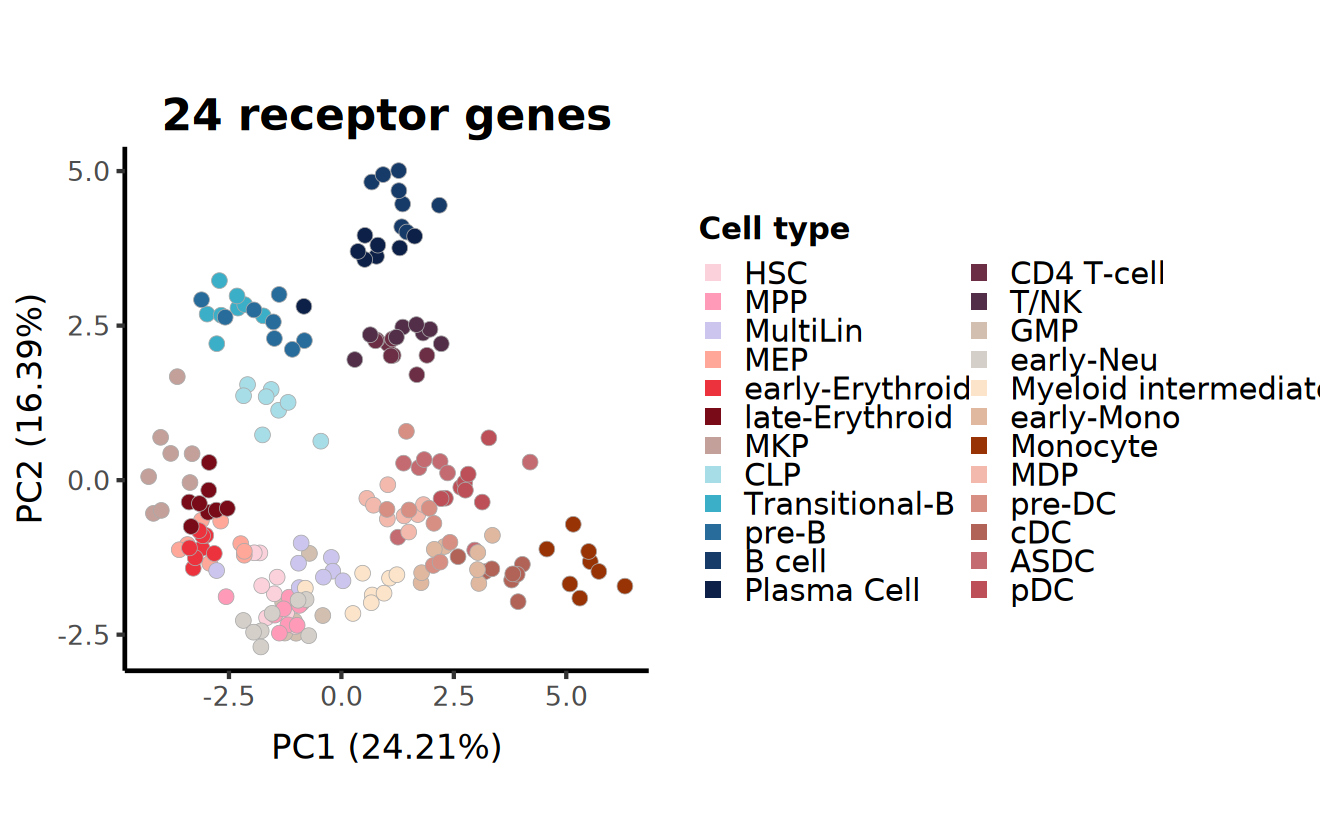

In [198]:
logcpm_CC = logcpm[receptor_genes,]
logcpm_CC_t = t(logcpm_CC)

pca <- prcomp((logcpm_CC_t), scale. = TRUE)

pca_df <- data.frame(pca$x[, 1], pca$x[, 2])


variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)


fig (11,7)
pca_plot4 <- plotmypca(pca_df, variance_pc1, variance_pc2, colorcode, sampleinfo) +
  ggtitle("24 receptor genes")

pca_plot4
#ggsave("pca_24_G1S_genes.pdf", plot = pca_plot, width = 11, height = 7, units = "in", dpi = 300)


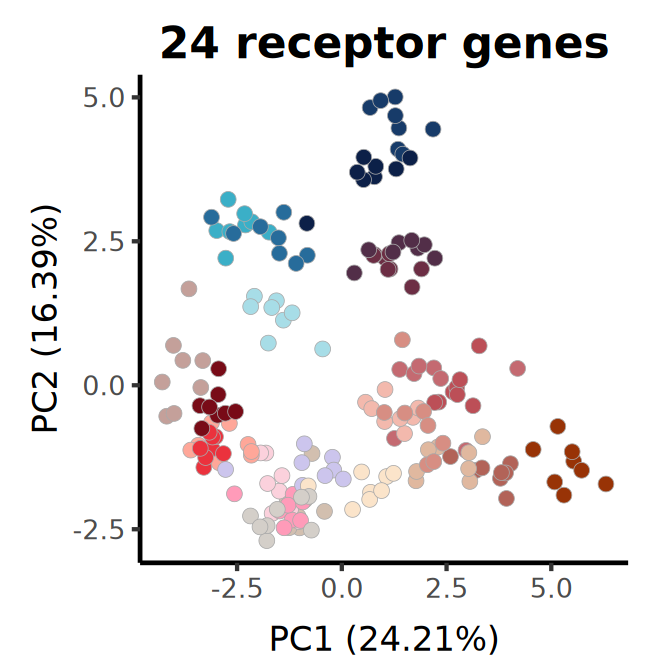

In [199]:
fig (5.5,5.5)

pca_plot4 = pca_plot4+theme(legend.position = "none")
pca_plot4

ggsave("./data/pca_plot4.pdf", plot = pca_plot4, width = 5.5, height = 5.5)#, units = "in", dpi = 300)


In [200]:
pca_receptors24 = pca_df %>%
rename (., "x" = "pca.x...1.", 
        "y" = "pca.x...2."
       )%>%
rownames_to_column ("sample")
head(pca_receptors24)

,sample,x,y
,<chr>,<dbl>,<dbl>
1,BM1_ASDC,1.381923,0.2746683
2,BM2_ASDC,2.195384,0.3016156
3,BM3_ASDC,1.725118,0.2022073
4,BM4_ASDC,4.196408,0.2917910
5,BM5_ASDC,2.964408,-1.1310639
6,BM6_ASDC,2.360652,0.1166450


In [201]:
write.csv(pca_receptors24, "./data/pca_receptors24.csv", 
          row.names = FALSE)


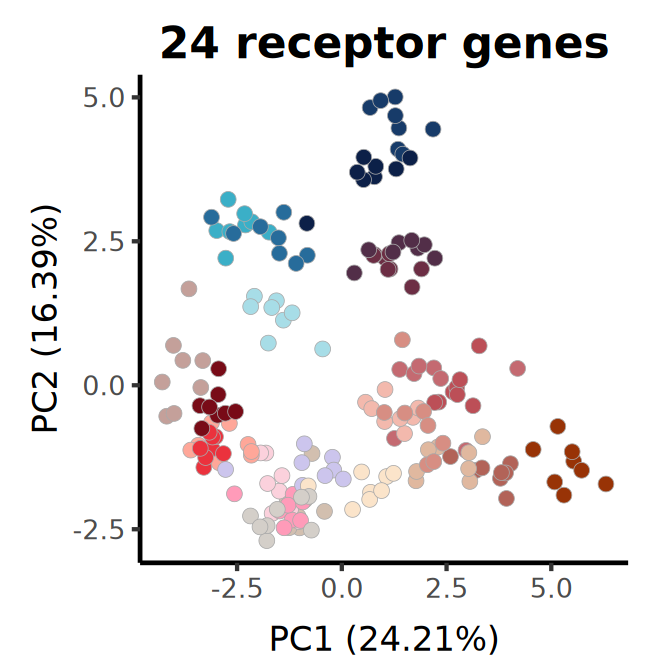

In [167]:
pca_plot4

## Calculate Pd for Level 1

[1] "AURKB"   "BIRC5"   "CCNA2"   "CDC20"   "CENPA"   "CENPI"   "CKAP5"  
 [8] "DDX21"   "ECT2"    "ESPL1"   "KIF11"   "KIF23"   "NCAPD2"  "NDC80"  
[15] "PLK1"    "POLR2B"  "RACGAP1" "RANGAP1" "RBBP6"   "RBMX"    "SF1"    
[22] "SFPQ"    "SMC4"    "SON"     "TOP2A"   "TPX2"    "WDR43"   "ZMAT2"  
[29] "KNL1"

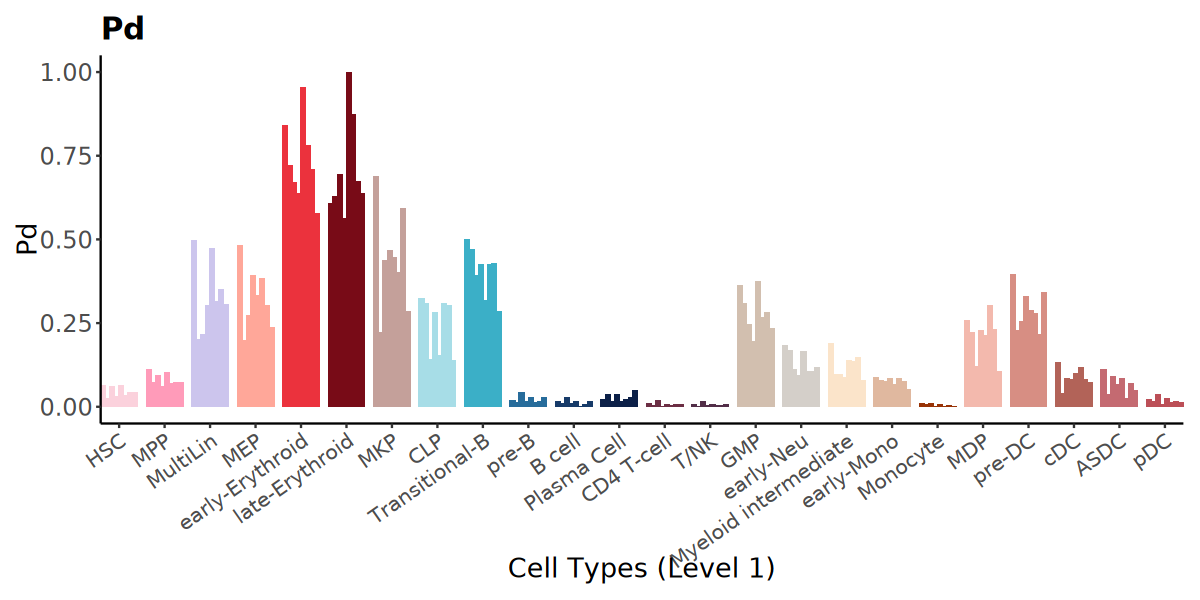

In [40]:
post_g1s = read.table ("/research/work/andreha/privat/Andrea/2024_Sylvain/data/postG1S_updated.csv", header = TRUE, sep = ",")
post_g1s = post_g1s$genes
post_g1s

x_pink <- x[post_g1s, ]

x_pink_normalized <- t(apply(x_pink, 1, function(gene_counts) {
  gene_counts / sampleinfo$psbulk_n_cells  
}))

x_pink_zscore <- t(apply(x_pink_normalized, 1, function(gene_counts) {
  (gene_counts - mean(gene_counts, na.rm = TRUE)) / sd(gene_counts, na.rm = TRUE)
}))

sample_avg_zscore <- colMeans(x_pink_zscore, na.rm = TRUE)

score_df <- data.frame(sample = names(sample_avg_zscore), avg_zscore = sample_avg_zscore)

combined_Pd_df <- merge(score_df, sampleinfo, by = "sample")

combined_Pd_df$prop2div <- (combined_Pd_df$avg_zscore - min(combined_Pd_df$avg_zscore)) /
                         (max(combined_Pd_df$avg_zscore) - min(combined_Pd_df$avg_zscore))

combined_Pd_df$`Level 1` <- factor(combined_Pd_df$`Level 1`, levels = names(colorcode))

barplot <- ggplot(combined_Pd_df, 
                  aes(x = `Level 1`, y = prop2div, fill = `Level 1`, group = `donor_id`)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), show.legend = FALSE) +  
  scale_fill_manual(values = colorcode) + 
  theme_classic() +
  theme(
    axis.text.x = element_text(angle = 35, hjust = 1, size = 12),
    axis.text.y = element_text(size = 14),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  labs(x = "Cell Types (Level 1)", y = "Pd", title = "Pd") +
  scale_x_discrete(expand = c(0, 0)) 

fig (10,5)
barplot

Warning message:
“package ‘classInt’ was built under R version 4.3.3”


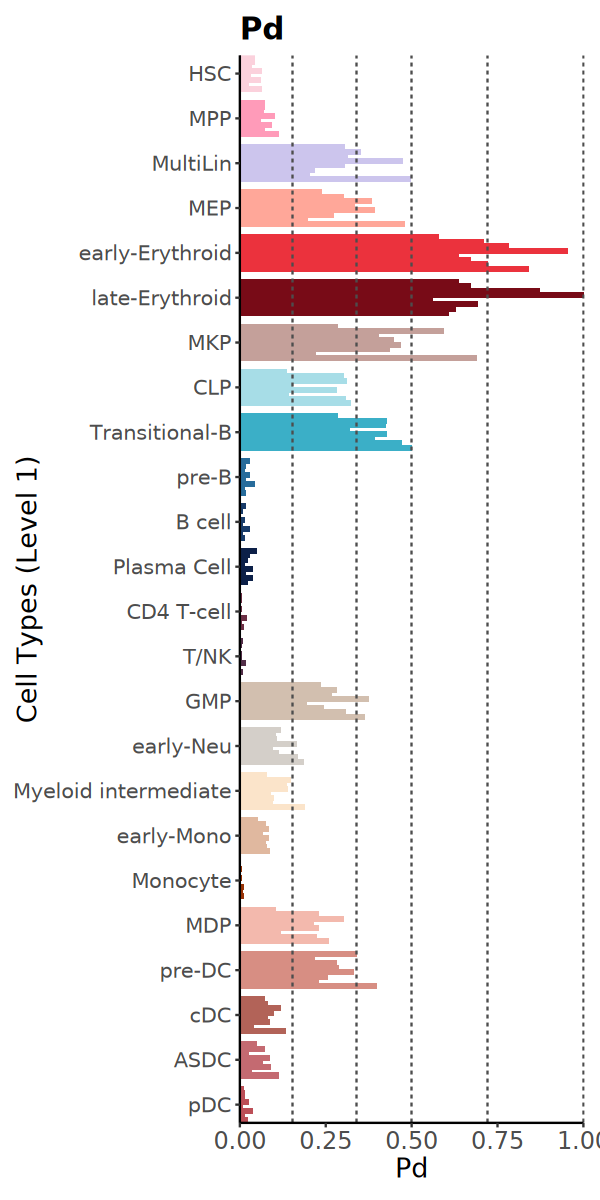

In [41]:
combined_Pd_df$`Level 1` <- factor(combined_Pd_df$`Level 1`, levels = rev(names(colorcode)))

#  Jenks breaks
jenks <- classIntervals(combined_Pd_df$prop2div, n = 5, style = "jenks")
jenks_breaks <- jenks$brks

fig(5, 10)
barplot <- ggplot(combined_Pd_df, 
                  aes(x = prop2div, y = `Level 1`, fill = `Level 1`, group = donor_id)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), show.legend = FALSE) +
  scale_fill_manual(values = colorcode) +
  geom_vline(xintercept = jenks_breaks, linetype = "dashed", color = "grey30", linewidth = 0.5) +
  theme_classic() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(size = 14),
    axis.title.y = element_text(size = 16),
    axis.title.x = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  labs(y = "Cell Types (Level 1)", x = "Pd", title = "Pd") +
  scale_y_discrete(expand = c(0, 0)) +
  scale_x_continuous(expand = c(0, 0))  # glue to axis

barplot


In [42]:
jenks_breaks <- jenks$brks
first_break <- jenks_breaks[2]  # [1] is always min value
first_break

[1] 0.1541186

In [43]:
jenks_breaks

[1] 0.0000000 0.1541186 0.3403526 0.4996255 0.7216018 1.0000000

In [44]:
library(dplyr)

sampleinfo <- sampleinfo %>%
  left_join(combined_Pd_df[, c("sample", "prop2div")], by = "sample")


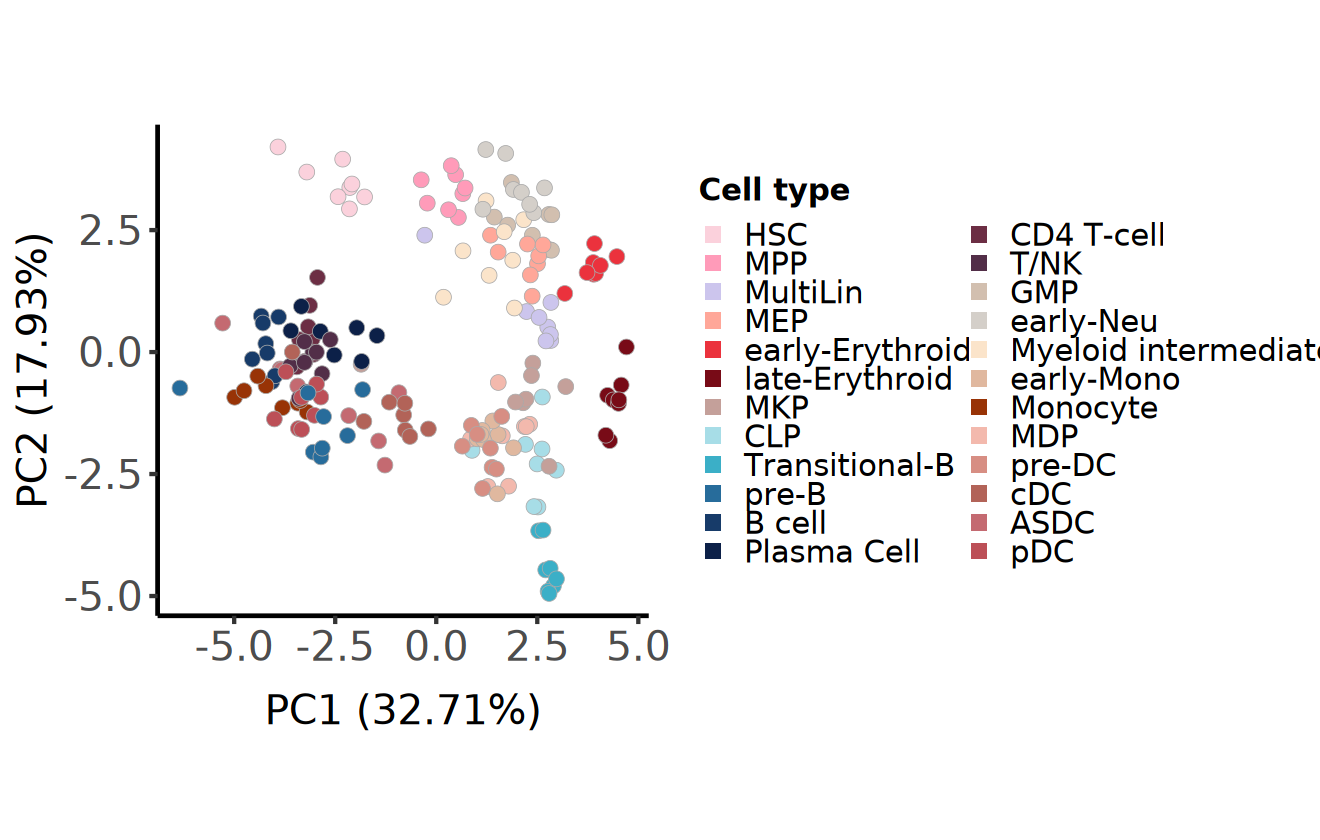

In [45]:
fig (11,7)

#----------------------------------------
logcpm_CC = logcpm[G1Sgenes,]
logcpm_CC_t = t(logcpm_CC)

pca <- prcomp((logcpm_CC_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)
#----------------------------------------

ggplot(pca_df, 
         aes(x = pca.x...1., 
             y = pca.x...2.,
             fill = sampleinfo$cell_type)) +  
    geom_point(shape = 21, size = 4, color = "darkgrey", stroke = 0.25) +  
    xlab(paste0("PC1 (", variance_pc1, "%)")) +
    ylab(paste0("PC2 (", variance_pc2, "%)")) +
    scale_fill_manual(values = colorcode) +
    theme_classic(base_size = 20, base_family = "sans") +
    theme(
      aspect.ratio = 1, 
      axis.text = element_text(size = 24), 
      axis.title = element_text(size = 24), 
      axis.title.x = element_text(vjust = -1),
      plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
      legend.title = element_text(color = "black", size = 18, face = "bold"), 
      legend.text = element_text(color = "black", size = 18),
      axis.line.x = element_line(size = 1),
      axis.line.y = element_line(size = 1)
    ) +
    labs(fill = "Cell type") +
    guides(
      fill = guide_legend(
        title = "Cell type",
        override.aes = list(shape = 22, size = 5, stroke = 0)  # squares in legend
      )
    )


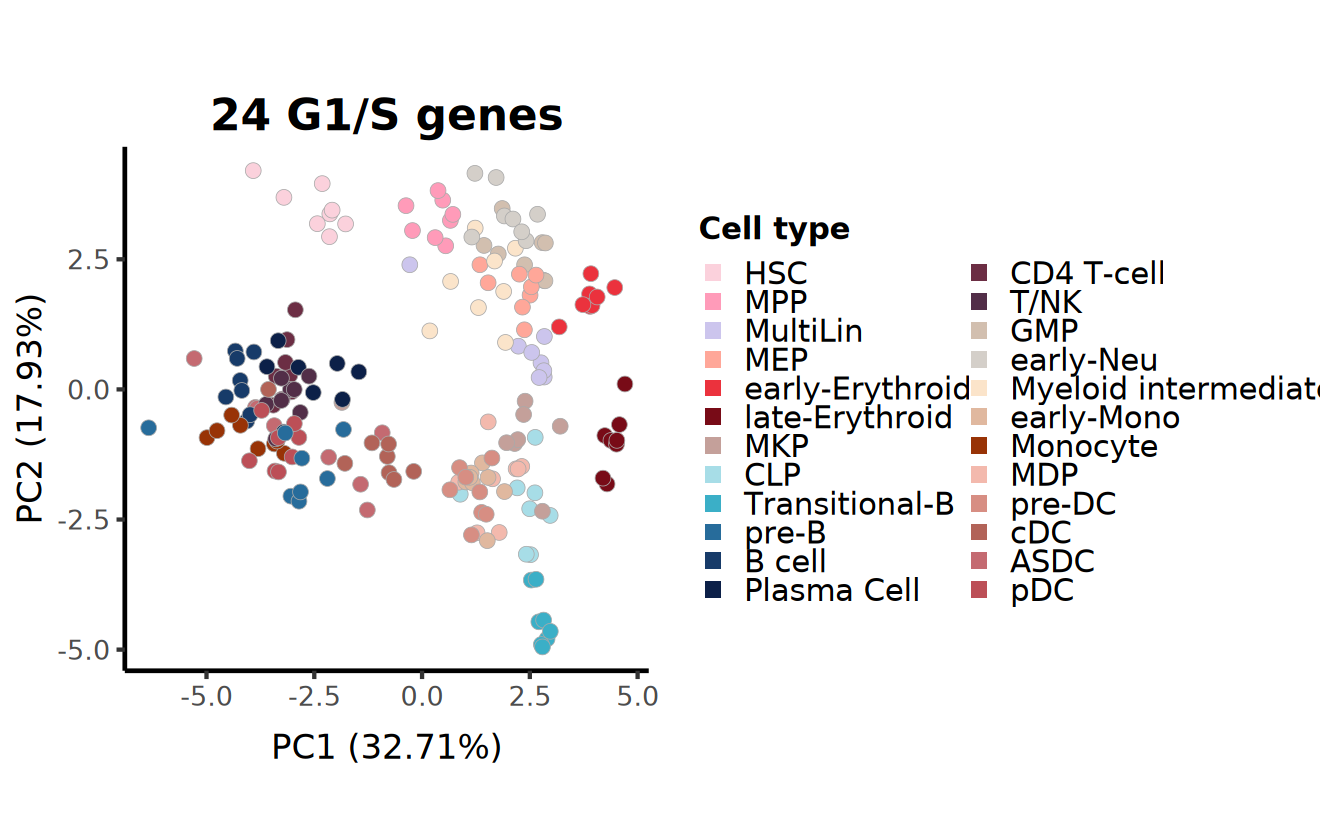

In [46]:
#--------
pca <- prcomp((logcpm_CC_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)

#fig (7,7)

fig (11,7)
pca_plot1 <- plotmypca(pca_df, variance_pc1, variance_pc2, colorcode, sampleinfo) +
  ggtitle("24 G1/S genes")

pca_plot1

#ggsave("pca_24_G1S_genes.pdf", plot = pca_plot, width = 11, height = 7, units = "in", dpi = 300)


In [47]:
q95 <- quantile(sampleinfo$prop2div, 0.95, na.rm = TRUE)

plotmypcaPd <- function(data, variance_pc1, variance_pc2, colorcode, sampleinfo) {
  ggplot(data, 
         aes(x = pca.x...1., 
             y = pca.x...2.,
           fill = sampleinfo$prop2div)) +  
    geom_point(shape = 21, size = 4, color = "darkgrey", stroke = 0.25) +  
    xlab(paste0("PC1 (", variance_pc1, "%)")) +
    ylab(paste0("PC2 (", variance_pc2, "%)")) +
    scale_fill_manual(values = colorcode) +
  theme_classic(base_size = 20, base_family = "sans") +
  theme(
    aspect.ratio = 1,
    axis.text = element_text(size = 24), 
    axis.title = element_text(size = 24),
    axis.title.x = element_text(vjust = -1),
    plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0),
    legend.title = element_text(color = "black", size = 18, face = "bold"), 
    legend.text = element_text(color = "black", size = 18),
    axis.line.x = element_line(size = 1),
    axis.line.y = element_line(size = 1)
  ) +
  guides(fill = guide_colorbar(barwidth = 1, barheight = 8))
}


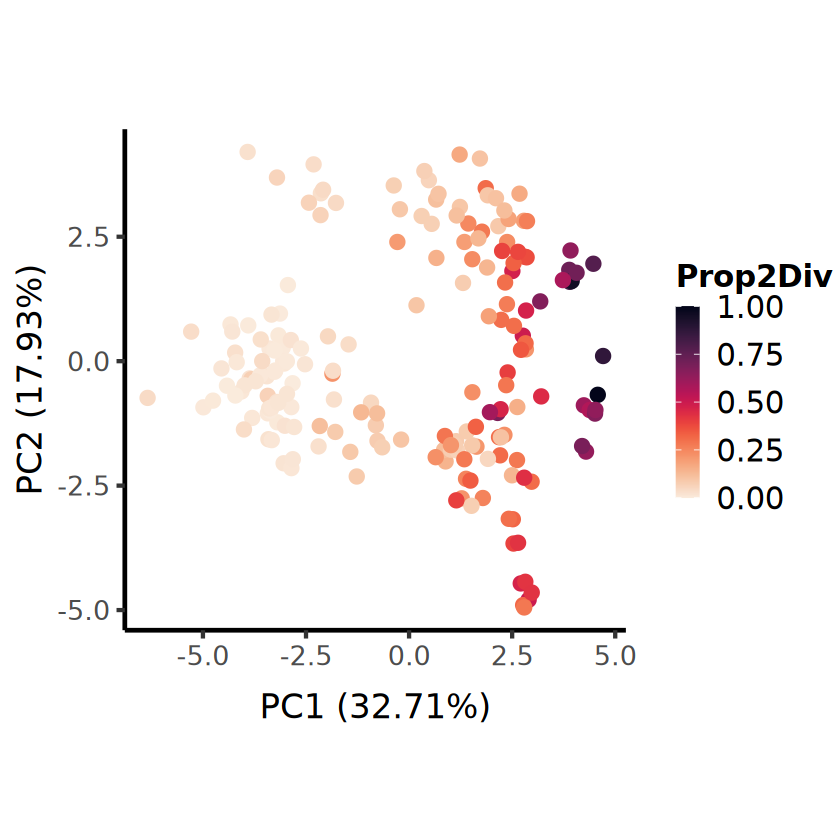

In [55]:
library(scales)
library(viridis)

#--------
G1Sgenes = c("CCND1","CCND2","CCND3","CCNE1","CCNE2", # cyclins
             "RB1","RBL1","RBL2", # RB related proteins
             "CDK2","CDK4","CDK6",
             "E2F1","E2F2","E2F3",
             "CDC25A","CDKN1A","CDKN1B","CDKN1C","CDKN2A","CDKN2B","CDKN2C","CDKN2D","CDKN3", "MYC")

logcpm_CC = logcpm[G1Sgenes,]
logcpm_CC_t = t(logcpm_CC)

pca <- prcomp((logcpm_CC_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)

fig(7, 7)

q95 <- quantile(sampleinfo$prop2div, 1, na.rm = TRUE)

# Add prop2div column into pca_df
pca_df$prop2div <- sampleinfo$prop2div

pca_plot5 = ggplot(pca_df, 
       aes(x = pca.x...1., 
           y = pca.x...2.,
           color = prop2div)) +   
  geom_point(shape = 16, size = 4) + 
  xlab(paste0("PC1 (", variance_pc1, "%)")) +
  ylab(paste0("PC2 (", variance_pc2, "%)")) +
  scale_color_viridis(
    option = "rocket",
    direction = -1,
    name = "Prop2Div",
    oob = squish,
    limits = c(min(sampleinfo$prop2div, na.rm = TRUE), q95)
  ) +
  theme_classic(base_size = 20, base_family = "sans") +
    theme(
      aspect.ratio = 1, 
      axis.text = element_text(size = 16), 
      axis.title = element_text(size = 20), 
      axis.title.x = element_text(vjust = -1),
      plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
      legend.title = element_text(color = "black", size = 18, face = "bold"), 
      legend.text = element_text(color = "black", size = 18),
      axis.line.x = element_line(size = 1),
      axis.line.y = element_line(size = 1)
  ) +
  guides(color = guide_colorbar(barwidth = 1, barheight = 8)) 

pca_plot5


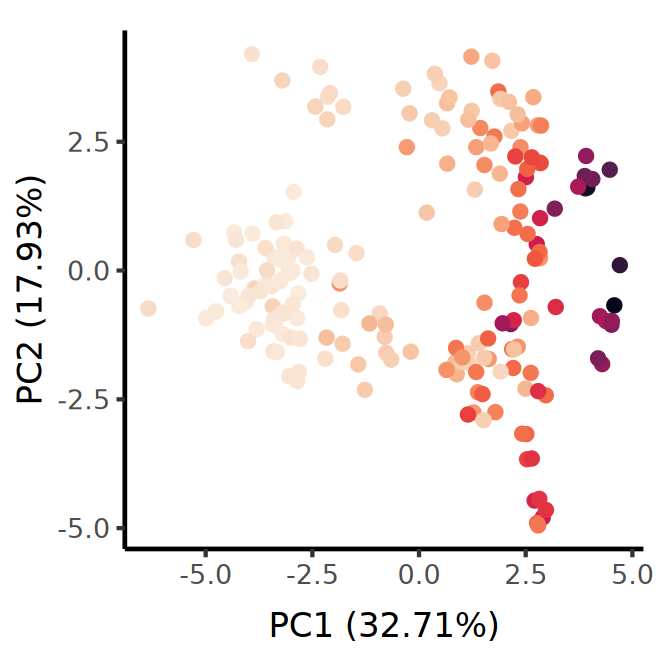

In [52]:
fig (5.5,5.5)

pca_plot5 = pca_plot5+theme(legend.position = "none")
pca_plot5
# Save the plot

ggsave("./data/pca_pd_g1s.pdf", 
       plot = pca_plot5, width = 5.5, height = 5.5)#, units = "in", dpi = 300)


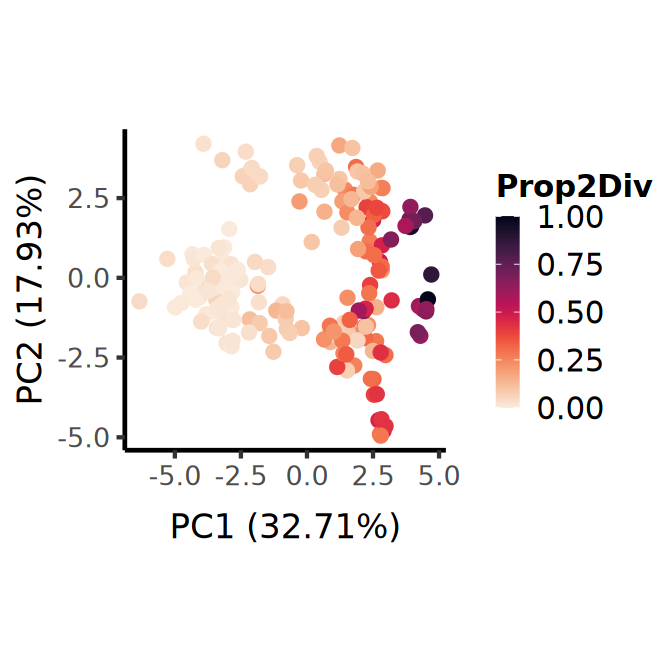

In [57]:
fig (5.5,5.5)

pca_plot5 = pca_plot5 #+theme(legend.position = "none")
pca_plot5


ggsave("./data/pca_Pd_legend.pdf", 
       plot = pca_plot5, width = 5.5, height = 5.5)#, units = "in", dpi = 300)

In [91]:
summary(sampleinfo$prop2div)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02577 0.10034 0.19533 0.30306 1.00000 

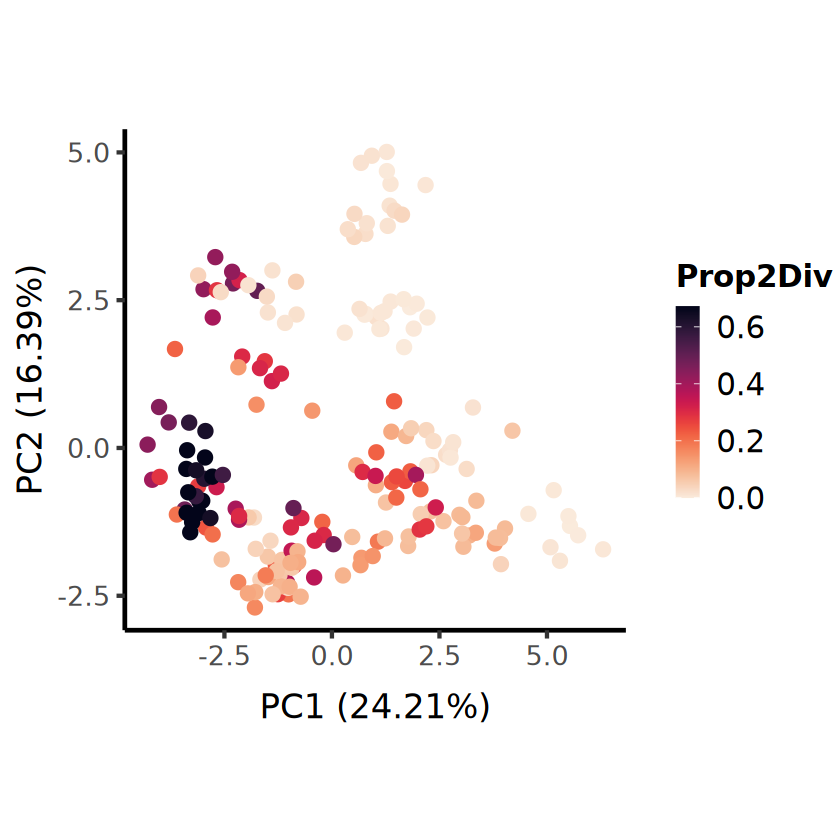

In [61]:
#---------------------------------------
logcpm_CC = logcpm[receptor_genes,]
logcpm_CC_t = t(logcpm_CC)

pca <- prcomp((logcpm_CC_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])
pca_df$prop2div <- sampleinfo$prop2div  

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)
#---------------------------------------

fig(7, 7)

q95 <- quantile(sampleinfo$prop2div, 0.95, na.rm = TRUE)

pca_plot6 = ggplot(pca_df, 
       aes(x = pca.x...1., 
           y = pca.x...2.,
           color = prop2div)) +  
  geom_point(shape = 16, size = 4) + 
  xlab(paste0("PC1 (", variance_pc1, "%)")) +
  ylab(paste0("PC2 (", variance_pc2, "%)")) +
  scale_color_viridis(
    option = "rocket",
    direction = -1,
    name = "Prop2Div",
    oob = squish,
    limits = c(min(sampleinfo$prop2div, na.rm = TRUE), q95)
  ) +
  theme_classic(base_size = 20, base_family = "sans") +
  theme(
      aspect.ratio = 1, 
      axis.text = element_text(size = 16), 
      axis.title = element_text(size = 20), 
      axis.title.x = element_text(vjust = -1),
      plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
      legend.title = element_text(color = "black", size = 18, face = "bold"), 
      legend.text = element_text(color = "black", size = 18),
      axis.line.x = element_line(size = 1),
      axis.line.y = element_line(size = 1)
  ) +
  guides(color = guide_colorbar(barwidth = 1, barheight = 8)) 

pca_plot6


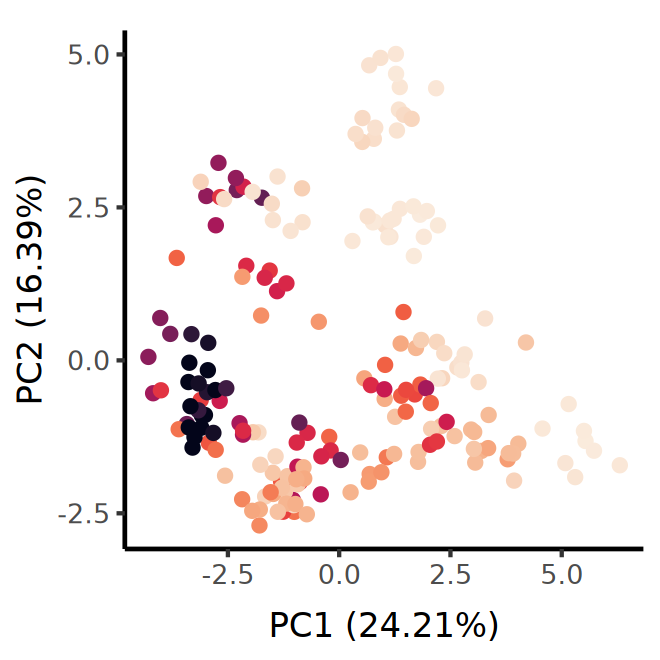

In [62]:
fig (5.5,5.5)

pca_plot6 = pca_plot6+theme(legend.position = "none")
pca_plot6
# Save the plot

ggsave("./data/pca_BMniche_Pd.pdf", plot = pca_plot6, width = 5.5, height = 5.5)#, units = "in", dpi = 300)


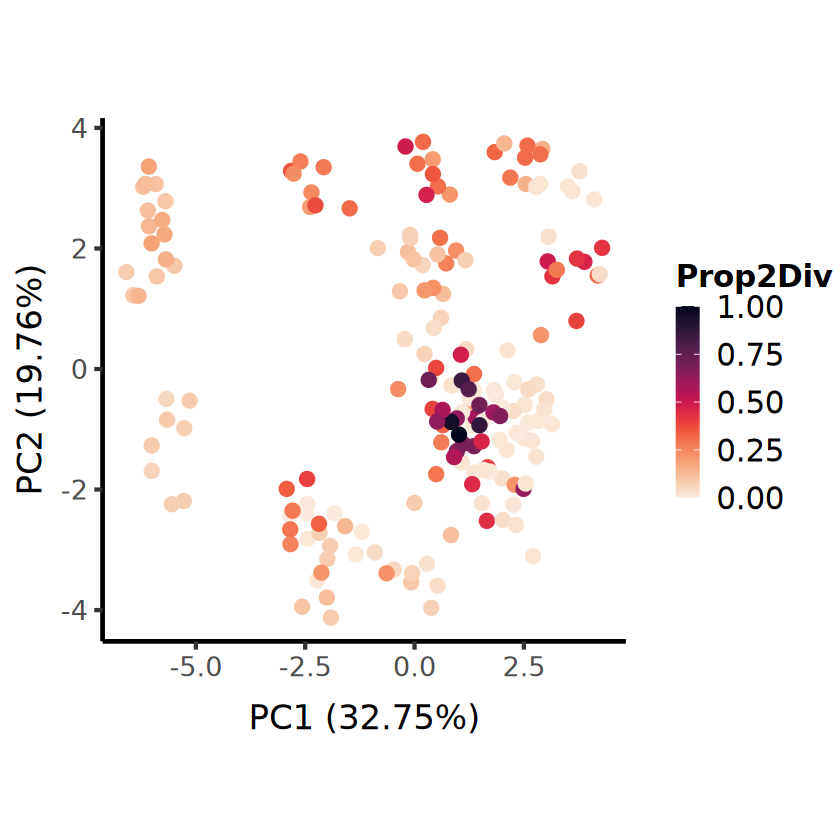

In [64]:
#---------------------------------------
m = as.matrix(logcpm)

o <- order(rowVars(m), decreasing = TRUE)
cpm_ordered <- m[o,]

vargenes = rownames(cpm_ordered[1:24,])

cpm_ordered = cpm_ordered[vargenes,]
cpm_ordered_t = t(cpm_ordered)

pca <- prcomp((cpm_ordered_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])
pca_df$prop2div <- sampleinfo$prop2div  # add prop2div to pca_df

variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)
#---------------------------------------

fig(7, 7)

q95 <- quantile(sampleinfo$prop2div, 1, na.rm = TRUE)

pca_plot7 = ggplot(pca_df, 
       aes(x = pca.x...1., 
           y = pca.x...2.,
           color = prop2div)) +  
  geom_point(shape = 16, size = 4) + 
  xlab(paste0("PC1 (", variance_pc1, "%)")) +
  ylab(paste0("PC2 (", variance_pc2, "%)")) +
  scale_color_viridis(
    option = "rocket",
    direction = -1,
    name = "Prop2Div",
    oob = squish,
    limits = c(min(sampleinfo$prop2div, na.rm = TRUE), q95)
  ) +
  theme_classic(base_size = 20, base_family = "sans") +
  theme(
    aspect.ratio = 1, 
    axis.text = element_text(size = 16), 
    axis.title = element_text(size = 20), 
    axis.title.x = element_text(vjust = -1),
    plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
    legend.title = element_text(color = "black", size = 18, face = "bold"), 
    legend.text = element_text(color = "black", size = 18),
    axis.line.x = element_line(size = 1),
    axis.line.y = element_line(size = 1)
  ) +
  guides(color = guide_colorbar(barwidth = 1, barheight = 8)) 

pca_plot7


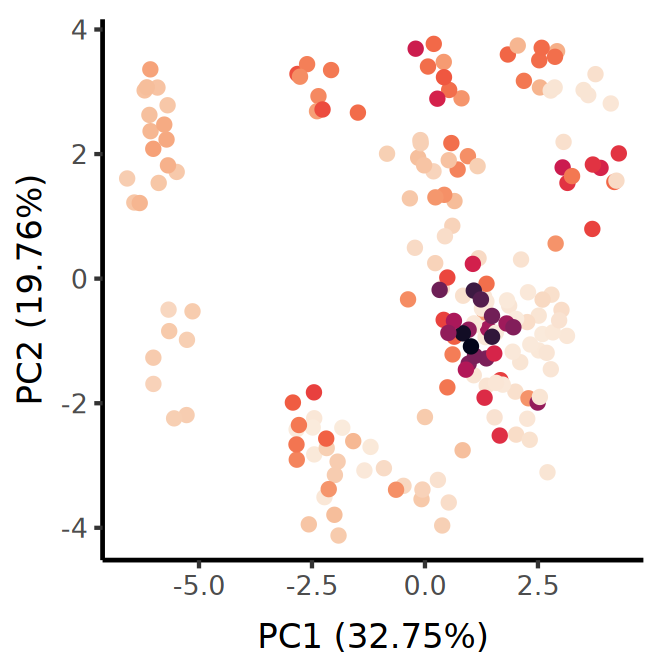

In [65]:
fig (5.5,5.5)

pca_plot7 = pca_plot7+theme(legend.position = "none")
pca_plot7

ggsave("./data/pca_hvg_Pd.pdf", plot = pca_plot7, width = 5.5, height = 5.5)#, units = "in", dpi = 300)


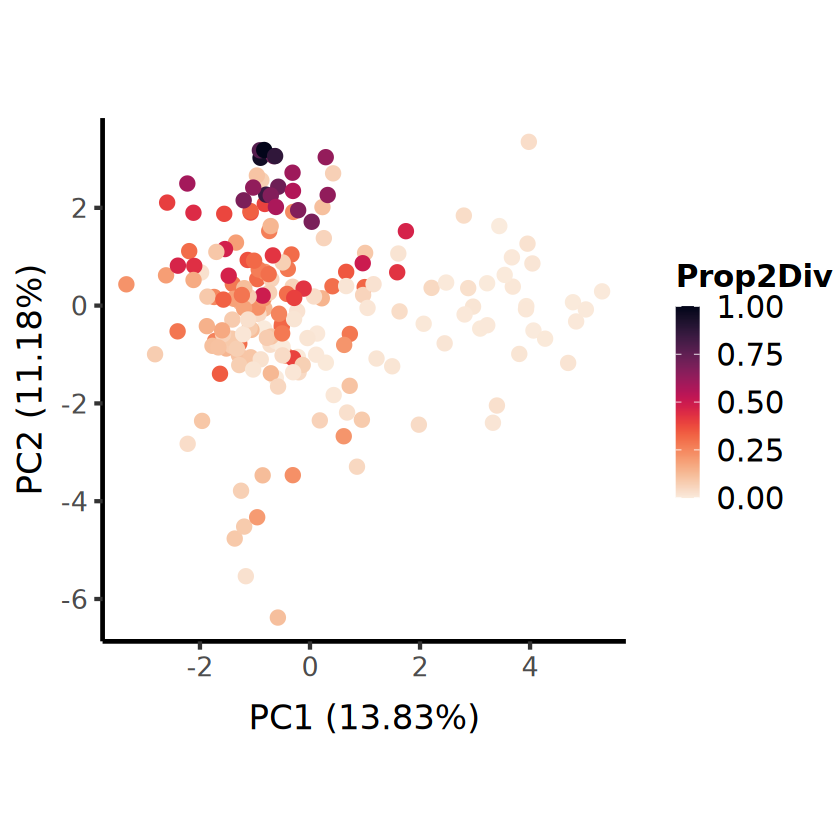

In [70]:
set.seed(42)

logcpm2 = data.frame(logcpm) %>%
  rownames_to_column("gene")

logcpm3 <- data.table(logcpm2)
randomgenes = (logcpm3[sample(.N, 24)])$gene

logcpm_random = logcpm[randomgenes,]
logcpm_random_t = t(logcpm_random)

pca <- prcomp((logcpm_random_t), scale. = TRUE)
pca_df <- data.frame(pca$x[, 1], pca$x[, 2])
pca_df$prop2div <- sampleinfo$prop2div  


variance_pc1 <- round(summary(pca)$importance["Proportion of Variance", "PC1"] * 100, 2)
variance_pc2 <- round(summary(pca)$importance["Proportion of Variance", "PC2"] * 100, 2)
#---------------------------------------

fig(7, 7)

q95 <- quantile(sampleinfo$prop2div, 1, na.rm = TRUE)

pca_plot8 = ggplot(pca_df, 
       aes(x = pca.x...1., 
           y = pca.x...2.,
           color = prop2div)) + 
  geom_point(shape = 16, size = 4) + 
  xlab(paste0("PC1 (", variance_pc1, "%)")) +
  ylab(paste0("PC2 (", variance_pc2, "%)")) +
  scale_color_viridis(
    option = "rocket",
    direction = -1,
    name = "Prop2Div",
    oob = squish,
    limits = c(min(sampleinfo$prop2div, na.rm = TRUE), q95)
  ) +
  theme_classic(base_size = 20, base_family = "sans") +
  theme(
    aspect.ratio = 1, 
    axis.text = element_text(size = 16), 
    axis.title = element_text(size = 20), 
    axis.title.x = element_text(vjust = -1),
    plot.title = element_text(hjust = 0.5, size = 26, vjust = 0, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 20, vjust = 0), 
    legend.title = element_text(color = "black", size = 18, face = "bold"), 
    legend.text = element_text(color = "black", size = 18),
    axis.line.x = element_line(size = 1),
    axis.line.y = element_line(size = 1)
  ) +
  guides(color = guide_colorbar(barwidth = 1, barheight = 8)) 

pca_plot8

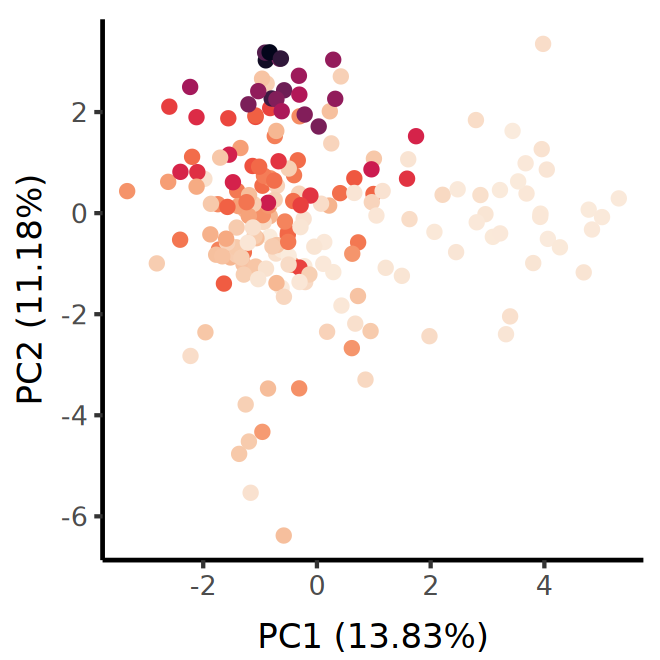

In [72]:
fig (5.5,5.5)

pca_plot8 = pca_plot8+theme(legend.position = "none")
pca_plot8
# Save the plot

ggsave("./data/pca_random_Pd.pdf", plot = pca_plot8, width = 5.5, height = 5.5)#, units = "in", dpi = 300)


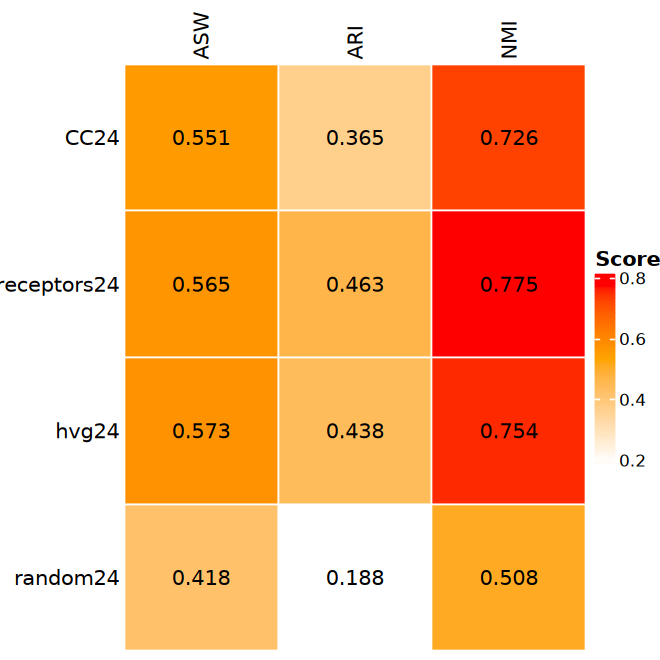

In [74]:
library(ComplexHeatmap)
library(circlize)

mat <- matrix(c(
  0.551, 0.365, 0.726,
  0.565, 0.463, 0.775,
  0.573, 0.438, 0.754,
  0.418, 0.188, 0.508
), 
nrow = 4, byrow = TRUE)

rownames(mat) <- c("CC24", "receptors24", "hvg24", "random24")
colnames(mat) <- c("ASW", "ARI", "NMI")

col_fun <- colorRamp2(
  c(min(mat), mean(mat), max(mat)), 
  c("white", "orange", "red")
)

Heatmap(
  mat,
  name = "Score",
  col = col_fun,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  column_names_side = "top",
  row_names_side = "left",
  rect_gp = gpar(col = "white"), 
  cell_fun = function(j, i, x, y, width, height, fill) {
    grid.text(sprintf("%.3f", mat[i, j]), x, y, gp = gpar(fontsize = 12))
  },
  heatmap_legend_param = list(
    legend_height = unit(4, "cm"),
    title_gp = gpar(fontsize = 12, fontface = "bold"),
    labels_gp = gpar(fontsize = 10)
  )
)
